### 1. Loading dependencies and data

In [1]:
## Se cargan los datos usando la librearía de UCIM como se indica en la página
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 

np.random.seed(seed=1)

# fetch dataset 
loaded_dataset = fetch_ucirepo(id=229) 
  
# data (as pandas dataframes) 
X = loaded_dataset.data.features 
y = loaded_dataset.data.targets

obj_var = y.columns[0]

## Concat data to get an unique dataframe
df = pd.concat([X, y], axis=1)
df.head()

,B,G,R,y
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


### 2. Preprocessing data

In [2]:
## data length
rows, cols = df.shape
print(f'Total {rows=}')
print(f'Total {cols=}')

Total rows=245057
Total cols=4


In [3]:
## Data types:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B       245057 non-null  int64
 1   G       245057 non-null  int64
 2   R       245057 non-null  int64
 3   y       245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


,B,G,R,y
count,245057.000000,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151,1.792461
std,62.255653,59.941197,72.562165,0.405546
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


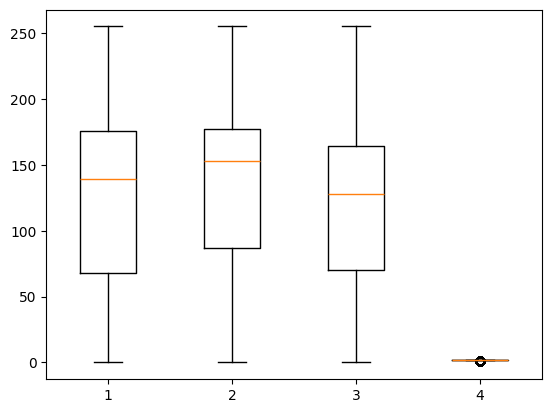

In [4]:
## Box plot by attrib
display(df.describe())

plt.boxplot(df)
plt.show()

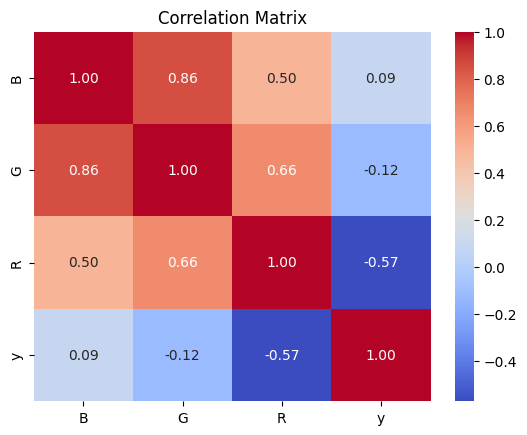

In [5]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [6]:
## Count prediction varaible objetive labels distribution
df[obj_var].value_counts()

y
2    194198
1     50859
Name: count, dtype: int64

In [7]:
## Null values
display(df.isnull().sum(axis=0))

B    0
G    0
R    0
y    0
dtype: int64

In [8]:
df.sample(10)

,B,G,R,y
146088,4,0,5,2
206154,23,194,248,2
133069,196,195,157,2
110870,11,11,0,2
178123,179,174,149,2
243563,11,9,9,2
81193,63,63,23,2
118712,65,69,34,2
24152,67,116,172,1
131831,153,152,114,2


In [9]:
## There is a class imbalance so
g = df.groupby(obj_var)
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
balanced_df

C:\Users\ccsar\AppData\Local\Temp\ipykernel_17312\263310703.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


B    G    R  y
y                        
1 0      168  184  230  1
  1      168  184  237  1
  2       67  126  188  1
  3      128  166  220  1
  4      149  191  255  1
...      ...  ...  ... ..
2 50854   23   21    3  2
  50855   45   46   12  2
  50856  196  195  157  2
  50857  180  177  133  2
  50858   61   65   24  2

[101718 rows x 4 columns]

In [10]:
## Transforming cathegorical data:
from sklearn.preprocessing import scale

## scale numerical data
numerical_cols = ['R', 'G', 'B']
for col in numerical_cols:
    balanced_df[col] = scale(balanced_df[col])

In [11]:
# ## Manage outliers
# from pyod.models.knn import KNN   # kNN detector

# # train kNN detector
# clf_name = 'KNN'
# clf = KNN()
# clf.fit(balanced_df)

# outlier, outlier_confidence = clf.predict(balanced_df, return_confidence=True)
# pd.Series(outlier).value_counts()

### 3. Modelling

In [12]:
## USING K-FOLDS
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

# prepare the K-Fold cross-validation procedure
n_splits = 10
cv = KFold(n_splits=n_splits)

## Shuffle dataframe
balanced_df = balanced_df.sample(n=101718)

res = []
matrix = []
for train, test in cv.split(balanced_df):

    ## Split data
    y_train = balanced_df.iloc[train]['y']
    X_train = balanced_df.iloc[train][['R', 'G', 'B']]
    y_test = balanced_df.iloc[test]['y']
    X_test = balanced_df.iloc[test][['R', 'G', 'B']]
    
    ## Train model
    logisticRegr = LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)
    logisticRegr.fit(X_train, y_train)

    ## Prediction
    predictions = logisticRegr.predict(X_test)

    ## Confusion matrix
    confusion_matrix = metrics.confusion_matrix(np.array(y_test), predictions)
    matrix.append(confusion_matrix)
    tn, fp, fn, tp = confusion_matrix.ravel()
    specificity = tn / (tn+fp)
    display(confusion_matrix)

    ## Extract metrics from models
    model_metrics = metrics.classification_report(np.array(y_test), predictions, output_dict=True)
    accuracy = model_metrics['accuracy']
    precision, recall, f1_score, support = model_metrics['macro avg'].values()
    res.append([accuracy, precision, recall, f1_score, support, specificity])

cols = ['accuracy', 'precision', 'recall', 'f1_score', 'support', 'specificity']
results = pd.DataFrame(res, columns=cols)
results

array([[4830,  156],
       [ 415, 4771]])

array([[4968,  158],
       [ 387, 4659]])

array([[4888,  173],
       [ 417, 4694]])

array([[4957,  168],
       [ 406, 4641]])

array([[4929,  150],
       [ 419, 4674]])

array([[4900,  201],
       [ 407, 4664]])

array([[4871,  162],
       [ 419, 4720]])

array([[4929,  190],
       [ 432, 4621]])

array([[4880,  172],
       [ 435, 4684]])

array([[4993,  184],
       [ 401, 4593]])

,accuracy,precision,recall,f1_score,support,specificity
0,0.943866,0.944607,0.944345,0.943864,10172.0,0.968712
1,0.946422,0.947465,0.946241,0.946372,10172.0,0.969177
2,0.941998,0.942925,0.942114,0.941977,10172.0,0.965817
3,0.943571,0.944681,0.943388,0.943516,10172.0,0.967220
4,0.944062,0.945279,0.944098,0.944027,10172.0,0.970467
5,0.940228,0.940997,0.940168,0.940196,10172.0,0.960596
6,0.942882,0.943805,0.943140,0.942870,10172.0,0.967812
7,0.938852,0.939963,0.938695,0.938796,10172.0,0.962883
8,0.940321,0.941368,0.940488,0.940298,10171.0,0.965954
9,0.942484,0.943570,0.942081,0.942394,10171.0,0.964458


In [13]:
## K-Fold mean matrix
mean_matrix = np.mean(matrix, axis=0)
display(mean_matrix)

# Extract the values from the confusion matrix
tn, fp, fn, tp = mean_matrix.ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)  # Total correct predictions / Total predictions
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # TP / (TP + FP)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # Harmonic mean of precision and recall
support = tp + fn  # Total actual positive cases
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # TN / (TN + FP)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Support: {support}")
print(f"Specificity: {specificity:.4f}")

array([[4914.5,  171.4],
       [ 413.8, 4672.1]])

Accuracy: 0.9425
Precision: 0.9646
Recall: 0.9186
F1 Score: 0.9411
Support: 5085.900000000001
Specificity: 0.9663


In [15]:
## RANDOM SUBSAMPLIG
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

# prepare the K-Fold cross-validation procedure
n_splits = 10
cv = KFold(n_splits=n_splits)

## Shuffle dataframe
balanced_df = balanced_df.sample(n=101718)

res = []
matrix = []
for _ in range(10):

    ## Define test_size as % of total data
    test_size = 0.30

    ## Divide dataframe into train and test data
    divided_data = train_test_split(balanced_df.drop('y', axis=1), balanced_df['y'], test_size=test_size)
    X_train, X_test, y_train, y_test = divided_data
    
    ## Train model
    logisticRegr = LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)
    logisticRegr.fit(X_train, y_train)

    ## Prediction
    predictions = logisticRegr.predict(X_test)

    ## Confusion matrix
    confusion_matrix = metrics.confusion_matrix(np.array(y_test), predictions)
    matrix.append(confusion_matrix)
    tn, fp, fn, tp = confusion_matrix.ravel()
    specificity = tn / (tn+fp)
    display(confusion_matrix)

    ## Extract metrics from models
    model_metrics = metrics.classification_report(np.array(y_test), predictions, output_dict=True)
    accuracy = model_metrics['accuracy']
    precision, recall, f1_score, support = model_metrics['macro avg'].values()
    res.append([accuracy, precision, recall, f1_score, support, specificity])

cols = ['accuracy', 'precision', 'recall', 'f1_score', 'support','specificity']
results = pd.DataFrame(res, columns=cols)
results

array([[14726,   505],
       [ 1262, 14023]])

array([[14741,   520],
       [ 1246, 14009]])

array([[14726,   514],
       [ 1256, 14020]])

array([[14569,   538],
       [ 1245, 14164]])

array([[14656,   563],
       [ 1211, 14086]])

array([[14757,   594],
       [ 1261, 13904]])

array([[14708,   563],
       [ 1242, 14003]])

array([[14713,   494],
       [ 1249, 14060]])

array([[14734,   526],
       [ 1257, 13999]])

array([[14676,   521],
       [ 1230, 14089]])

,accuracy,precision,recall,f1_score,support,specificity
0,0.942096,0.943153,0.942140,0.942065,30516.0,0.966844
1,0.942129,0.943136,0.942124,0.942095,30516.0,0.965926
2,0.941998,0.943023,0.942026,0.941967,30516.0,0.966273
3,0.941572,0.942339,0.941795,0.941561,30516.0,0.964387
4,0.941867,0.942623,0.941920,0.941846,30516.0,0.963007
5,0.939212,0.940152,0.939077,0.939165,30516.0,0.961305
6,0.940851,0.941740,0.940832,0.940819,30516.0,0.963133
7,0.942882,0.943905,0.942964,0.942856,30516.0,0.967515
8,0.941572,0.942590,0.941568,0.941538,30516.0,0.965531
9,0.942620,0.943505,0.942712,0.942599,30516.0,0.965717


In [16]:
## K-Fold mean matrix
mean_matrix = np.mean(matrix, axis=0)
display(mean_matrix)

# Extract the values from the confusion matrix
tn, fp, fn, tp = mean_matrix.ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)  # Total correct predictions / Total predictions
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # TP / (TP + FP)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # Harmonic mean of precision and recall
support = tp + fn  # Total actual positive cases
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # TN / (TN + FP)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Support: {support}")
print(f"Specificity: {specificity:.4f}")

array([[14700.6,   533.8],
       [ 1245.9, 14035.7]])

Accuracy: 0.9417
Precision: 0.9634
Recall: 0.9185
F1 Score: 0.9404
Support: 15281.6
Specificity: 0.9650


## Valoración del análisis:

El modelo tiene un muy buen comportamiento con respecto a los datos presentados. Los esquemas de validación tienen un resultado muy similar. Existe un "empate técnico" entre los dos métodos de evaluación porque aunque los resultados de kFold son ligeramente mejores, tienen una desviación estándar ligeramente mayor que los del random subsamplig. Se concluye con los dos métodos de evaluación que el modelo es robusto, lo que nos permite afirmar que es un buen modelo predictivo.

#### Resultados de kFold
array([[4914.5,  171.4], <br>
       [ 413.8, 4672.1]])
* Accuracy: 0.9425
* Precision: 0.9646
* Recall: 0.9186
* F1 Score: 0.9411
* Support: 5085.900000000001
* Specificity: 0.9663

#### Resultados de random subsampling
array([[14700.6,   533.8], <br>
       [ 1245.9, 14035.7]])
* Accuracy: 0.9417
* Precision: 0.9634
* Recall: 0.9185
* F1 Score: 0.9404
* Support: 15281.6
* Specificity: 0.9650

